In [75]:
import thicket as th
from glob import glob

files = glob("group-cali-files/**/*.cali")
data = th.Thicket.from_caliperreader(files)
data.metadata_columns_to_perfdata("input_size")
data.metadata_columns_to_perfdata("num_procs")
data.metadata_columns_to_perfdata("input_type")
data.metadata_columns_to_perfdata("algorithm")

(2/2) Creating Thicket: 100%|██████████| 559/559 [00:05<00:00, 97.23it/s] 


In [76]:
print(data.tree(["Avg time/rank"]))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2025.1.0

0.466 main
├─ 0.001 data_init_runtime
├─ 0.009 comp
│  ├─ nan comp_large
│  ├─ 0.008 comp_small
│  └─ 0.001 comp_large
├─ 0.001 comm
│  ├─ 0.001 comm_large
│  ├─ nan comm_small
│  └─ nan comm_large
└─ 0.001 correctness_check

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.47 indices: {'profile': np.int64(12664303082)})
█ 0.42 - 0.47
█ 0.33 - 0.42
█ 0.23 - 0.33
█ 0.14 - 0.23
█ 0.05 - 0.14
█ 0.00 - 0.05

name User code    ◀  Only in left graph    ▶  Only in right graph



In [77]:
node_strings = ["comp_large", "comm", "main"]

## Strong Scaling Time Plots

In [78]:
import matplotlib.pyplot as plt
def plot_runtimes(x, ys, leg_labels, title, figname, inp_size):
    _, ax = plt.subplots()
    ax.plot(x, ys[0], 'x--', label=leg_labels[0], markersize=10)
    ax.plot(x, ys[1], '.--', label=leg_labels[1])
    # ax.plot(x, ys[2], 'o--', label=leg_labels[2], fillstyle='none')
    # ax.plot(x, ys[3], 'p--', label=leg_labels[3], fillstyle='none')
    ax.set_xscale('log', base=2)
    ax.set_xlabel(f"Number of Processes (log 2 scaled)")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"{title} Time Strong Scaling (Input Size={inp_size})")
    ax.legend()
    # plt.savefig(f"plots/strong-time/{figname}.png", dpi=600, bbox_inches="tight")
    plt.show()

{'name': 'comp_large', 'type': 'function'} Merge Sort 0 65536
{'name': 'comm', 'type': 'function'} Merge Sort 0 65536
{'name': 'main', 'type': 'function'} Merge Sort 0 65536
{'name': 'comp_large', 'type': 'function'} Merge Sort 1 65536
{'name': 'comm', 'type': 'function'} Merge Sort 1 65536
{'name': 'main', 'type': 'function'} Merge Sort 1 65536
{'name': 'comp_large', 'type': 'function'} Merge Sort 2 65536
{'name': 'comm', 'type': 'function'} Merge Sort 2 65536
{'name': 'main', 'type': 'function'} Merge Sort 2 65536
{'name': 'comp_large', 'type': 'function'} Merge Sort 3 65536
{'name': 'comm', 'type': 'function'} Merge Sort 3 65536
{'name': 'main', 'type': 'function'} Merge Sort 3 65536
{'name': 'comp_large', 'type': 'function'} Merge Sort 0 65536
{'name': 'comm', 'type': 'function'} Merge Sort 0 65536
{'name': 'main', 'type': 'function'} Merge Sort 0 65536
{'name': 'comp_large', 'type': 'function'} Merge Sort 1 65536
{'name': 'comm', 'type': 'function'} Merge Sort 1 65536
{'name': 'ma

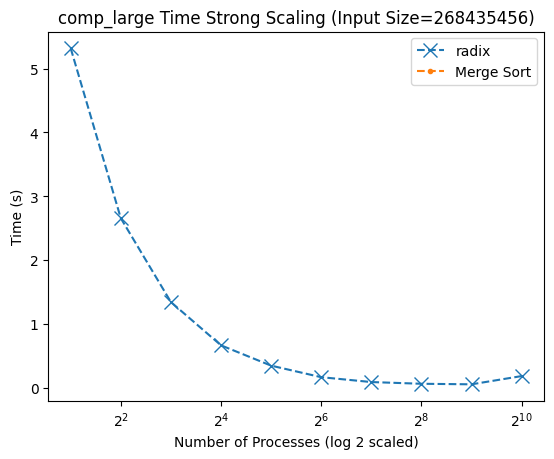

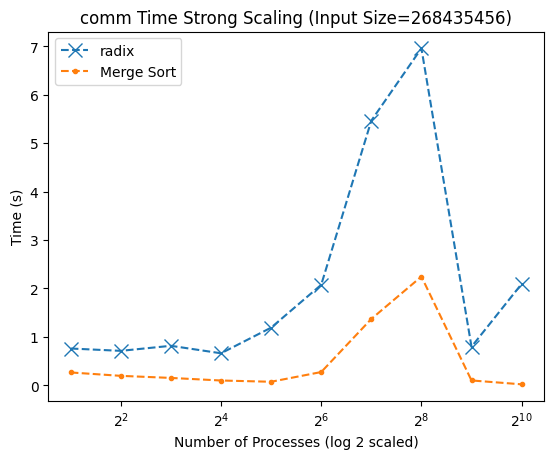

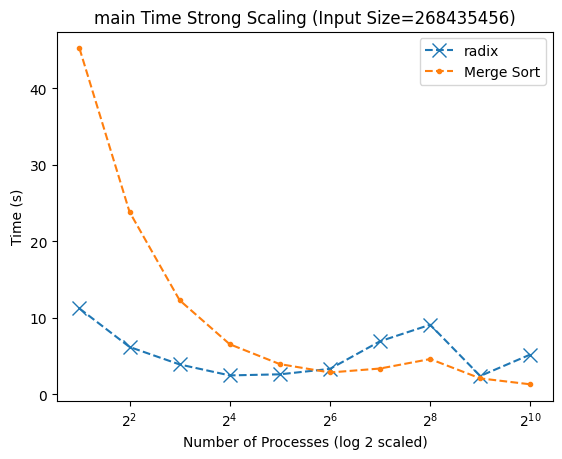

In [79]:
from copy import deepcopy
sub_data = data.groupby([ "algorithm", "input_size", "num_procs", "input_type"])

desired_size = 2**28
num_procs = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
algorithms = {"radix": [], "Merge Sort": []}

ys_time = {node : deepcopy(algorithms) for node in node_strings}

for cols, thic in sub_data.items():
    for node_string in node_strings:
        
        node = thic.get_node(node_string)
        algorithm = thic.dataframe.loc[node, "algorithm"].values[0]
        sort_level = thic.dataframe.loc[node, "input_type"].values[0]
        inp_size = int(thic.dataframe.loc[node, "input_size"].values.flatten()[0])
        print(node, algorithm, sort_level, inp_size)
        
        if inp_size != desired_size or sort_level!=2:
            continue
       
        y_avg = float(thic.dataframe.loc[node, "Avg time/rank"].values.flatten()[0])
        ys_time[node_string][algorithm].append(y_avg)

for node_string in node_strings:
    leg_labels = list(ys_time[node_string].keys())
    ys = list(ys_time[node_string].values())
    
    plot_runtimes(num_procs, ys, leg_labels, node_string, None, desired_size)


## Strong Scaling Speedup

In [80]:
def plot_speedup(x, ys, leg_labels, title, sort_level, figname):
    _, ax = plt.subplots()
    ax.plot(x, ys[0], 'x--', label=leg_labels[0], markersize=10)
    ax.plot(x, ys[1], '.--', label=leg_labels[1])
    # ax.plot(x, ys[2], 'o--', label=leg_labels[2], fillstyle='none')
    # ax.plot(x, ys[3], 'p--', label=leg_labels[3], fillstyle='none')
    ax.set_xscale('log', base=2)
    ax.set_xlabel(f"Number of Processes (log 2 scaled)")
    ax.set_ylabel("Speedup Factor")
    ax.set_title(f"{title} Speedup Factor Strong Scaling (Sort Level={sort_level})")
    ax.legend()
    # plt.savefig(f"plots/strong-speedup/{figname}.png", dpi=600, bbox_inches="tight")
    plt.show()

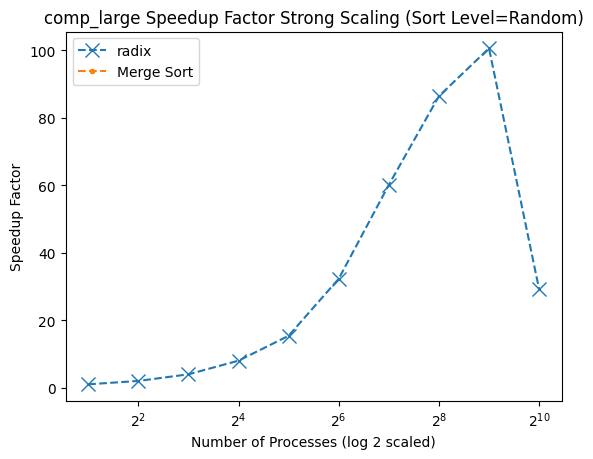

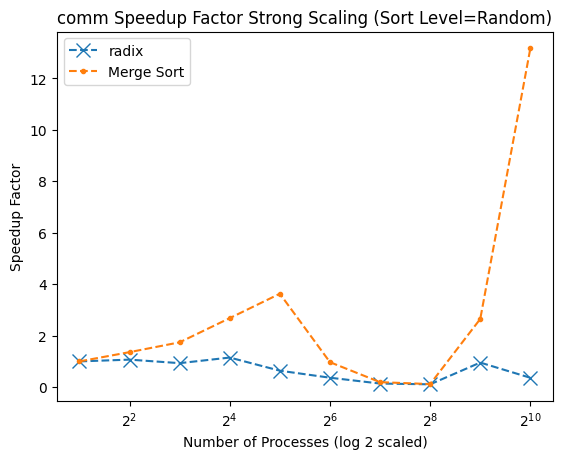

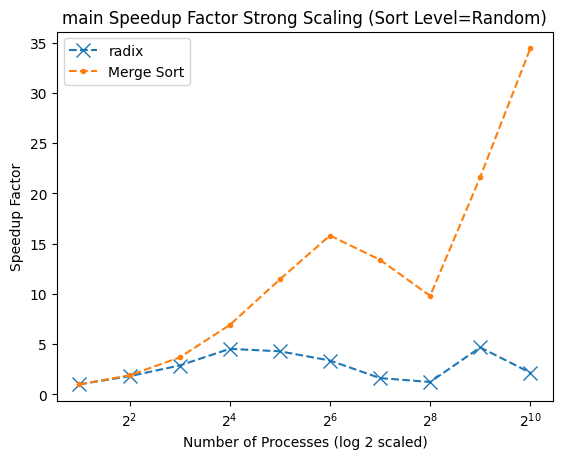

In [81]:
for node in node_strings:
    y_scaling = []
    for sort, times in ys_time[node].items():
        runtimes = times
        speedup = [runtimes[0]/x for x in runtimes]
        y_scaling.append(speedup)
    plot_speedup(num_procs, y_scaling, leg_labels, node, "Random", None)